In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib.image as mpimg

### Jump to next section(section 2) if camera calibration is already done

### 1. Camera calibration

In [2]:
#Prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Array to store object points and image points from all images
objpoints = []  #3D points in real world space
imgpoints = []  #2D points in image plane

#Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Step through the list and search for chessboard corners
for idx, frame in enumerate(images):
    img = cv2.imread(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    #If found, add Object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        

#### Calculate distortion coefficients

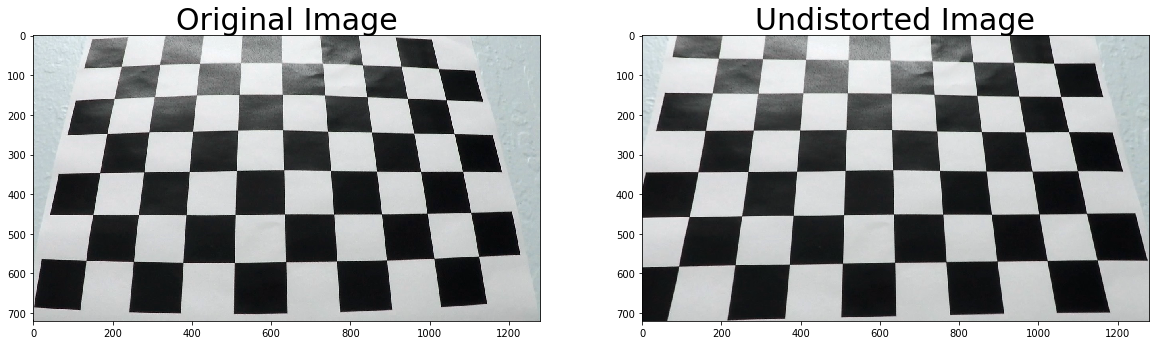

In [3]:
%matplotlib inline

img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])
                 
#Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#Apply undistortion on a sample image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist.jpg',dst)

#Save the camera calibration
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open('camera_cal/dist_pickle.p',"wb"))

#Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


### Start from here if camera calibration is already done

### 2. Applying Camera calibration

In [2]:
#Loading the camera calibration parameters
with open('camera_cal/dist_pickle.p', mode='rb') as in_file:
    dist_pickle = pickle.load(in_file)
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


In [3]:
def undistort(img, img_path = None):
    #Apply undistortion on a sample image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    if img_path != None: #If undistorted images are not saved at proper folder, check the path deliminator in img_path
        img_name = img_path.split("/")[-1]
        path = img_path.split("/")[0]
        img_name = "undist_" + img_name
        path = path+'/'+img_name
        cv2.imwrite(path,dst)
    
    return dst

In [4]:
def color_gradient_thresh(undistorted_img,s_thresh=(170,255),sx_thresh=(20,100)):
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]   
    s_channel = hls[:,:,2]
    
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1)|(sxbinary == 1)] = 1
    
    
    #return s_binary
    return combined_binary
    

### 3. Apply Camera calibration on test images, skip this part if testing on image not required

In [44]:
#Apply Calibration and Threshold on test images and save
images = glob.glob('test_images/test*.jpg')
    
for idx, frame in enumerate(images):
    img = cv2.imread(frame)
    
    undist = undistort(img, img_path = frame)
    binary_output = color_gradient_thresh(undist,s_thresh=(170,255))
    
    
print("Done")


Done


True

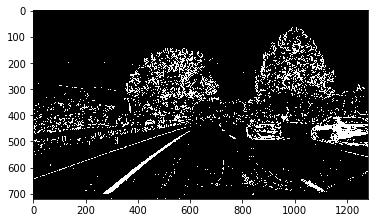

In [5]:
## Test undistortion and threshold on a single Image
img = cv2.imread('test_images/test1.jpg')
undist = undistort(img)
binary_output = color_gradient_thresh(undist,s_thresh=(140,255),sx_thresh=(20,100))
plt.imshow(binary_output, cmap='gray')

out_img = np.dstack((binary_output, binary_output, binary_output))*255 
cv2.imwrite('output_images/binary_combo_test1.jpg',out_img)

## If Perspective calculation is already done, jump to next section 5

### 4. Perspective Calculation

[[ 294.  661.]
 [1002.  661.]
 [ 703.  461.]
 [ 579.  461.]]
[[ 294.  710.]
 [1002.  710.]
 [1002.   50.]
 [ 294.   50.]]


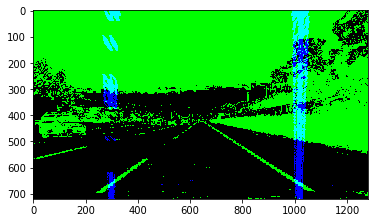

In [18]:
img = cv2.imread('test_images/straight_lines2.jpg')

undist= undistort(img)
binary_output = color_gradient_thresh(undist,s_thresh=(70,255),sx_thresh=(20,100))
#plt.imshow(binary_output,cmap='gray')

height = binary_output.shape[0]
width = binary_output.shape[1]
#print(height)
#print(width)

img_size = (binary_output.shape[1], binary_output.shape[0])

#Masking with a ploygon
vertices = np.array([[(0,height),(width*0.45, height*0.62),(width*0.55, height*0.62),
                          (width, height)]],dtype=np.int32)
mask = np.zeros_like(binary_output)
ignore_mask_color = 255
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_image = cv2.bitwise_and(binary_output, mask)
#plt.imshow(masked_image,cmap='gray')

histogram_bottom = np.sum(masked_image[height-60:height-58,:], axis=0)#For the bottom rectangle
histogram_upper = np.sum(masked_image[height-260:height-258,:], axis=0) # For the upper rectangle
#plt.plot(histogram_upper)


midpoint = np.int(histogram_bottom.shape[0]/2)
leftx_base = np.argmax(histogram_bottom[:midpoint])
rightx_base = np.argmax(histogram_bottom[midpoint:]) + midpoint

leftx_upper = np.argmax(histogram_upper[:midpoint])
rightx_upper = np.argmax(histogram_upper[midpoint:]) + midpoint

#print(leftx_base)
#print(rightx_base)
#print(leftx_upper)
#print(rightx_upper)

offset = 50

src = np.float32([[leftx_base,height-59],[rightx_base,height-59],[rightx_upper,height-259],[leftx_upper,height-259]])
dst = np.float32([[leftx_base,height-10],[rightx_base,height-10],[rightx_base,offset],[leftx_base,offset]])

print(src)
print(dst)

M = cv2.getPerspectiveTransform(src, dst)
#warped = cv2.warpPerspective(masked_image, M, img_size, flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(binary_output, M, img_size, flags=cv2.INTER_LINEAR)

stacked_image = np.dstack((np.zeros_like(binary_output), binary_output, warped))*255

#Save M in pickle
perspective_pickle = {}
perspective_pickle["M"] = M
pickle.dump(perspective_pickle, open('test_images/perspective_pickle.p',"wb"))

plt.imshow(stacked_image)


### 5. Applying Perspective

In [5]:
#Loading M
with open('test_images/perspective_pickle.p', mode='rb') as in_file:
    perspective_pickle = pickle.load(in_file)
M = perspective_pickle["M"]
Minv = np.linalg.inv(M)

### Skip Next test if testing not required

True

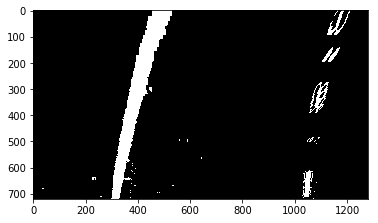

In [7]:
#Apply Perspective on a test image
img = cv2.imread('test_images/test3.jpg')

undist = undistort(img)
binary_output1 = color_gradient_thresh(undist,s_thresh=(70,255),sx_thresh=(20,100))

img_size = (binary_output1.shape[1], binary_output1.shape[0])
binary_warped = cv2.warpPerspective(binary_output1, M, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(binary_warped,cmap='gray')
#plt.imshow(stacked_image)



out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
cv2.imwrite('output_images/warped_test3.jpg',out_img)

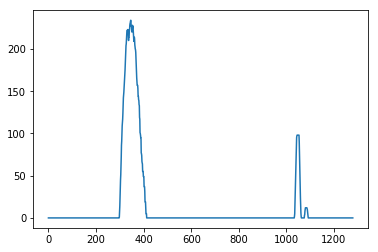

In [49]:
# Finding Lanes
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### 6. Finding the Lanes and other helper function

In [6]:
#Sliding Windows
def find_lanes(binary_warped, last_detected = False, last_left_fit = [], last_right_fit =[], visualization=False):
    detected = False
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if last_detected == True:
        margin = 100
        left_lane_inds = ((nonzerox > (last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + 
        last_left_fit[2] - margin)) & (nonzerox < (last_left_fit[0]*(nonzeroy**2) + 
        last_left_fit[1]*nonzeroy + last_left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + 
        last_right_fit[2] - margin)) & (nonzerox < (last_right_fit[0]*(nonzeroy**2) + 
        last_right_fit[1]*nonzeroy + last_right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        
        if len(leftx)>100: # len(lefty) = len(leftx)
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit = [np.array([False])]
        
        if len(rightx) > 100:
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit = [np.array([False])]
        
    else:
        # Take a histogram of the bottom half of the image
        #print(binary_warped.shape)
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
    
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
        #for window in range(1):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
         
            # Identify the nonzero pixels in x and y within the window
    
    
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    
    
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        #print(len(left_lane_inds))
        #print(len(right_lane_inds))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        #print(len(righty))
        #print(len(rightx))
        # Fit a second order polynomial to each
        
        if len(leftx)>100: # len(lefty) = len(leftx)
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit = [np.array([False])]
            
        if len(rightx) > 100:
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit = [np.array([False])]
    
    if left_fit[0] and right_fit[0]:
        if visualization:
            #Visualization
            #At this point, we are done! But here is how you can visualize the result as well:

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
        
        
            out_img[np.array(ploty).astype(int), np.array(left_fitx).astype(int)] = [0, 255, 0]
            out_img[np.array(ploty).astype(int), np.array(right_fitx).astype(int)] = [0, 255, 0]
            cv2.imwrite('output_images/color_fit_lines.jpg',out_img)
        
        
        
        ### Calculate radius of curvature in meters #########
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        y_eval = binary_warped.shape[0]
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
    
    
        ###Calculate the distance of car center from a lane
        leftx_at_y_eval = left_fit_cr[0] * (y_eval*ym_per_pix)**2 + left_fit_cr[1] * y_eval*ym_per_pix + left_fit_cr[2]
        rightx_at_y_eval = right_fit_cr[0] * (y_eval*ym_per_pix)**2 + right_fit_cr[1] * y_eval*ym_per_pix + right_fit_cr[2]
        #midx_lane = np.mean([leftx_at_y_eval,rightx_at_y_eval])
        midx_car = binary_warped.shape[1] * xm_per_pix / 2
        left_lane_base_pos = midx_car - leftx_at_y_eval
        right_lane_base_pos = rightx_at_y_eval - midx_car
    
        ###Sanity check
        ###To Check lane detected or not
        leftx_at_top = left_fit_cr[0] * (0*ym_per_pix)**2 + left_fit_cr[1] * 0 *ym_per_pix + left_fit_cr[2]
        rightx_at_top = right_fit_cr[0] * (0*ym_per_pix)**2 + right_fit_cr[1] * 0 *ym_per_pix + right_fit_cr[2]
        if rightx_at_top - leftx_at_top < 0.9* 3.7 or rightx_at_y_eval - leftx_at_y_eval < 0.9*3.7 or rightx_at_top - leftx_at_top > 1.1* 3.7 or rightx_at_y_eval - leftx_at_y_eval > 1.1*3.7 or left_fit[0].any() == False or right_fit[0].any() == False:
            #print("Wrong detection:Lane detection crossed")
            detected = False
        else:
            detected = True
        #print(rightx_at_y_eval - leftx_at_y_eval)
        #print(rightx_at_top - leftx_at_top)
    
        ###Calculate difference in fit coefficients between last and new fits
        if len(last_left_fit)>0:
            left_fit_diff_coeff = last_left_fit - left_fit
        else:
            left_fit_diff_coeff = last_left_fit
        if len(last_right_fit)>0:
            right_fit_diff_coeff = last_right_fit - right_fit
        else:
            right_fit_diff_coeff = last_right_fit
    else:
        left_curverad=0
        right_curverad=0
        deviation = False
        detected=False
        left_fit_diff_coeff=False
        right_fit_diff_coeff=False
        left_lane_base_pos=False
        right_lane_base_pos=False
        
    
    return (left_fit,right_fit,left_curverad,right_curverad,detected,left_fit_diff_coeff,
            right_fit_diff_coeff,leftx,lefty,rightx,righty,left_lane_base_pos,right_lane_base_pos)

In [7]:
def draw_lanes(undistorted,warped,left_fit,right_fit):
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

### 7. Test the whole sequence before applying to video, skip this if testing not required

Radius of curvature:
1025.55290864 m 829.815395895 m
Position of the car w.r.t center of lane:  0.216714749496 m


True

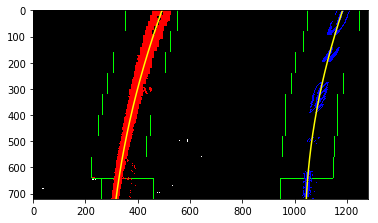

In [9]:
#Test the pipeline
img = cv2.imread('test_images/test3.jpg')

undist = undistort(img)
binary_output2 = color_gradient_thresh(undist,s_thresh=(140,255),sx_thresh=(20,100))

#Applying perspective
img_size2 = (binary_output2.shape[1], binary_output2.shape[0])
binary_warped2 = cv2.warpPerspective(binary_output2, M, img_size2, flags=cv2.INTER_LINEAR)

#Find Lanes and raduis of curvature
(left_fit,right_fit,left_curverad,right_curverad,detected,left_fit_diff_coeff,right_fit_diff_coeff,leftx,lefty,rightx,righty,left_lane_base_pos,right_lane_base_pos) = find_lanes(binary_warped2, 
                                                                                      last_detected = False,visualization=True)



result_img = draw_lanes(undist, binary_warped2,left_fit,right_fit)

radius_of_curv = (left_curverad+right_curverad)/2
radcurv_string = "Radius of Curvature = " + str(round(radius_of_curv,4)) +"(m)"
center_of_car = (right_lane_base_pos - left_lane_base_pos)/2
if center_of_car > 0:
    center_of_car_string = "Vehicle is " + str(round(abs(center_of_car),4)) +"m" + " left of center"
else:
    center_of_car_string = "Vehicle is " + str(round(abs(center_of_car),4)) +"m" + " right of center"
###Overlay Text on the image
font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText =(350,50)
bottomLeftCornerOfText2 =(350,100)
fontScale = 1
fontColor =(255,255,255)
lineType =2
cv2.putText(result_img,radcurv_string,bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
cv2.putText(result_img,center_of_car_string,bottomLeftCornerOfText2,font,fontScale,fontColor,lineType)


print('Radius of curvature:')
print(left_curverad, 'm', right_curverad, 'm')
print('Position of the car w.r.t center of lane: ',str((right_lane_base_pos - left_lane_base_pos)/2), 'm')
cv2.imwrite('output_images/example_output_test3.jpg',result_img)


### 8. Apply Lane detection on video

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
class MyVideoProcessor(object):
    # constructor function
    def __init__(self):
        # values of the last n fits of the line
        self.past_frames_left = []
        self.past_frames_right = []
        
        self.leftLane = Line()
        self.rightLane = Line()

        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None 
        self.best_fit_right = None 

    def pipeline(self, frame):
        # your lane detection pipeline
        
        undist = undistort(frame)
        binary_output = color_gradient_thresh(undist,s_thresh=(140,255),sx_thresh=(20,100))
        
        #Applying perspective
        img_size = (binary_output.shape[1], binary_output.shape[0])
        binary_warped = cv2.warpPerspective(binary_output, M, img_size, flags=cv2.INTER_LINEAR)
        
        if self.leftLane.detected & self.rightLane.detected:
            last_detected=True
        else:
            last_detected=False
        
        #Find Lanes and raduis of curvature
        (left_fit,right_fit,left_curverad,right_curverad,detected,left_fit_diff_coeff,right_fit_diff_coeff,leftx,lefty,rightx,righty,left_lane_base_pos,right_lane_base_pos) = find_lanes(binary_warped, 
                                                                                      last_detected = last_detected,
                                                                                      last_left_fit=self.leftLane.current_fit,
                                                                                      last_right_fit=self.rightLane.current_fit,
                                                                                      visualization=False)
        
        
        
        self.leftLane.detected = detected
        self.rightLane.detected = detected
        if detected:
            self.leftLane.current_fit = left_fit
            self.leftLane.radius_of_curvature = left_curverad
            self.leftLane.line_base_pos = left_lane_base_pos
            self.leftLane.diffs = left_fit_diff_coeff
            self.leftLane.allx = leftx
            self.leftLane.ally = lefty
        
            
            self.rightLane.current_fit = right_fit
            self.rightLane.radius_of_curvature = right_curverad
            self.rightLane.line_base_pos = right_lane_base_pos
            self.rightLane.diffs = right_fit_diff_coeff
            self.rightLane.allx = rightx
            self.rightLane.ally = righty
            
                                                                                                  
        result_img = draw_lanes(undist, binary_warped,self.leftLane.current_fit,self.rightLane.current_fit)
        
        
        radius_of_curv = (self.leftLane.radius_of_curvature+self.rightLane.radius_of_curvature)/2
        radcurv_string = "Radius of Curvature = " + str(round(radius_of_curv,4)) +"(m)"
        center_of_car = (self.rightLane.line_base_pos - self.leftLane.line_base_pos)/2
        if center_of_car > 0:
            center_of_car_string = "Vehicle is " + str(round(abs(center_of_car),4)) +"m" + " left of center"
        else:
            center_of_car_string = "Vehicle is " + str(round(abs(center_of_car),4)) +"m" + " right of center"
        ###Overlay Text on the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText =(350,50)
        bottomLeftCornerOfText2 =(350,100)
        fontScale = 1
        fontColor =(255,255,255)
        lineType =2
        cv2.putText(result_img,radcurv_string,bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        cv2.putText(result_img,center_of_car_string,bottomLeftCornerOfText2,font,fontScale,fontColor,lineType)
        
        return result_img
        

In [27]:
my_video_processor_object = MyVideoProcessor()
project_video_output = 'project_video_output.mp4'
#clip = VideoFileClip("project_video.mp4").subclip(0,4)
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:05<00:00,  6.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 7s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))